## Myokyung Han (20224230)

## 1. Download Data

In [1]:
# https://ca.finance.yahoo.com/quote/CADUSD%3DX/h|istory?period1=1063843200&period2=1649376000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [2]:
import pandas as pd
from pandas.tseries.offsets import YearEnd

In [3]:
def load_deepsearch_data(filepath, column):
    df = pd.read_excel(filepath)
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.set_index('날짜')
    df.columns = [column]
    
    return df
    

In [4]:
# yahoo finance에서 받아온 데이터 로딩
df_can_usd_xr = pd.read_csv('./data/usd_cad_xr.csv')
# df_can_usd_xr = pd.read_csv('./data/CAD.csv')
df_krw_usd_xr = load_deepsearch_data('./data/krw_usd_xr.xlsx', 'KRW/USD')


In [5]:
df_can_usd_xr['Date'] = pd.to_datetime(df_can_usd_xr['Date'])
df_can_usd_xr.set_index('Date' , inplace=True)
df_can_usd_xr = df_can_usd_xr['Close'].to_frame()
df_can_usd_xr = df_can_usd_xr.rename(columns = {'Close':'USD/CAD'})
df_xr_merged = df_can_usd_xr.join(df_krw_usd_xr)
df_xr_merged['KRW/CAD'] = df_xr_merged['USD/CAD'] * df_xr_merged['KRW/USD']
df_xr_merged[['KRW/CAD', 'USD/CAD', 'KRW/USD']].tail(10)

,KRW/CAD,USD/CAD,KRW/USD
Date,,,
2022-03-30,976.563547,0.800134,1220.5
2022-03-31,970.013047,0.801134,1210.8
2022-04-01,968.676227,0.800096,1210.7
2022-04-04,970.822359,0.798308,1216.1
2022-04-05,974.435563,0.800884,1216.7
2022-04-06,NaN,0.801000,NaN
2022-04-07,NaN,0.795938,NaN
2022-04-08,NaN,0.794489,NaN
2022-04-11,NaN,0.795165,NaN


In [6]:
df_xr_merged.dropna(inplace=True)

In [7]:
df_monthly = df_xr_merged.resample('M').last()[['USD/CAD']]

In [8]:
df_monthly.loc['2020-12-31']

USD/CAD    0.784271
Name: 2020-12-31 00:00:00, dtype: float64

In [9]:
# Real XR    0.928844
# USD/CAD    0.784271
# PPP XR    1.245722

In [10]:
1.245722/0.784271

1.5883820771136508

In [11]:
import matplotlib.pyplot as plt

In [12]:
plt.rcParams['figure.figsize'] = (8,4)

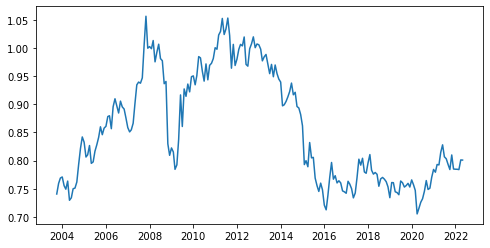

In [13]:
plt.plot(df_monthly)
plt.show()

In [14]:
# https://data.worldbank.org/indicator/PA.NUS.PPP?locations=CA

In [15]:
def load_world_bank_data(filepath, column):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)
    df = df.set_index('Country Code')
    df = df.loc['CAN'].to_frame()
    
    df = df.iloc[3:]
    df.dropna(inplace=True)
    df['CAN'] = df['CAN'].astype(float)
    df['date'] = pd.to_datetime(df.index)+YearEnd(0)
    df.set_index('date', inplace=True)
    df.columns = [column]
    return df
      
    

In [16]:
# https://data.worldbank.org/indicator/PA.NUS.PPPC.RF?locations=CA
# Price level ratio of PPP conversion factor (GDP) to market exchange rate/ CANADA
    
df_real_xr = load_world_bank_data('./data/world_real_xr.xls', 'Real XR')

In [17]:
df_real_xr.loc['2020-12-31']

Real XR    0.928844
Name: 2020-12-31 00:00:00, dtype: float64

In [18]:
df_ppp_xr = load_world_bank_data('./data/world_ppp_xr.xls', 'PPP XR')

In [19]:
df_ppp_xr.loc['2020-12-31']

PPP XR    1.245722
Name: 2020-12-31 00:00:00, dtype: float64

In [20]:
1.064069/1.241556

0.85704470841428

## Merge dataframes

In [21]:
df_merged = df_monthly.join(df_real_xr)

In [22]:
df_merged= df_merged.join(df_ppp_xr['PPP XR'])

In [23]:
df_merged.loc['2019-12-31']

USD/CAD    0.765662
Real XR    0.939745
PPP XR     1.246847
Name: 2019-12-31 00:00:00, dtype: float64

In [24]:
0.765662/1.246847

0.6140785517389061

In [25]:
import matplotlib.pyplot as plt

In [26]:
plt.rcParams['figure.figsize'] = (10,4)

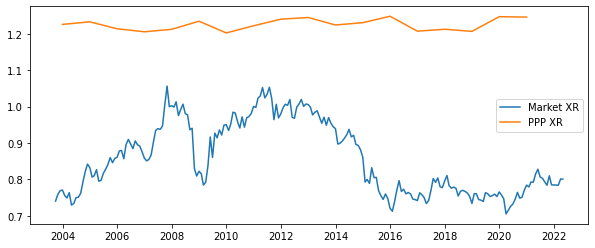

In [27]:
plt.plot(df_merged['USD/CAD'], label = 'Market XR')
plt.plot(df_merged['PPP XR'].dropna(), label = 'PPP XR')
plt.legend()
plt.show()


In [28]:
df_merged['PPP XR'] = df_merged['PPP XR'].fillna(method='ffill')

In [29]:
df_merged['New Real XR'] = \
    df_merged['PPP XR']/df_merged['USD/CAD']
# 이렇게 하는게 맞음....
#     df_merged['CAD/USD']/df_merged['PPP XR']>> 이게 맞음????아오

In [30]:
df_merged.head()

,USD/CAD,Real XR,PPP XR,New Real XR
Date,,,,
2003-09-30,0.740631,NaN,NaN,NaN
2003-10-31,0.759359,NaN,NaN,NaN
2003-11-30,0.768994,NaN,NaN,NaN
2003-12-31,0.770891,0.874823,1.225714,1.589997
2004-01-31,0.755458,NaN,1.225714,1.622478


In [31]:
df_merged['Real XR'] = df_merged['Real XR'].fillna(method='ffill')
df_merged['New Real XR'] = df_merged['New Real XR'].fillna(method='ffill')

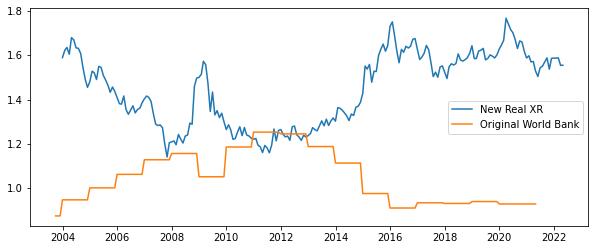

In [32]:
plt.plot(df_merged['New Real XR'], label = 'New Real XR')
# plt.plot(df_merged['Real XR'].shift(-12), label = 'Original World Bank')
plt.plot(df_merged['Real XR'].shift(-12), label = 'Original World Bank')
plt.legend()
plt.show()

In [33]:
df_merged

,USD/CAD,Real XR,PPP XR,New Real XR
Date,,,,
2003-09-30,0.740631,NaN,NaN,NaN
2003-10-31,0.759359,NaN,NaN,NaN
2003-11-30,0.768994,NaN,NaN,NaN
2003-12-31,0.770891,0.874823,1.225714,1.589997
2004-01-31,0.755458,0.874823,1.225714,1.622478
...,...,...,...,...
2021-12-31,0.784658,0.928844,1.245722,1.587599
2022-01-31,0.784578,0.928844,1.245722,1.587761
2022-02-28,0.783994,0.928844,1.245722,1.588943


In [34]:
df_merged[['New Real XR', 'Real XR']]

,New Real XR,Real XR
Date,,
2003-09-30,NaN,NaN
2003-10-31,NaN,NaN
2003-11-30,NaN,NaN
2003-12-31,1.589997,0.874823
2004-01-31,1.622478,0.874823
...,...,...
2021-12-31,1.587599,0.928844
2022-01-31,1.587761,0.928844
2022-02-28,1.588943,0.928844


### Compute annual returns in the currency market

In [35]:
df_merged['ann_ret'] = \
    df_merged['USD/CAD'].pct_change(periods=12)*100

In [36]:
df_merged['F12.ann_ret'] = \
    df_merged['ann_ret'].shift(-12)

In [37]:
df_merged.head(15)

,USD/CAD,Real XR,PPP XR,New Real XR,ann_ret,F12.ann_ret
Date,,,,,,
2003-09-30,0.740631,NaN,NaN,NaN,NaN,7.031302
2003-10-31,0.759359,NaN,NaN,NaN,NaN,8.190987
2003-11-30,0.768994,NaN,NaN,NaN,NaN,9.488891
2003-12-31,0.770891,0.874823,1.225714,1.589997,NaN,8.001001
2004-01-31,0.755458,0.874823,1.225714,1.622478,NaN,6.732869
2004-02-29,0.749232,0.874823,1.225714,1.635961,NaN,8.134196
2004-03-31,0.763592,0.874823,1.225714,1.605195,NaN,8.267242
2004-04-30,0.729501,0.874823,1.225714,1.680209,NaN,8.983949
2004-05-31,0.733945,0.874823,1.225714,1.670035,NaN,8.678307


### Use OLS!!!

In [38]:
import statsmodels.api as sm

In [39]:
df = df_merged[['New Real XR', 'F12.ann_ret']]
df = df.dropna()

In [40]:
X = df['New Real XR']
X = sm.add_constant(X)

/Users/boysbeanxious/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
Y = df['F12.ann_ret']

In [42]:
model = sm.OLS(Y,X)

In [43]:
results = model.fit()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     35.52
Date:                Tue, 12 Apr 2022   Prob (F-statistic):           1.07e-08
Time:                        20:12:19   Log-Likelihood:                -723.99
No. Observations:                 209   AIC:                             1452.
Df Residuals:                     207   BIC:                             1459.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -27.2999      4.707     -5.800      0.000     -36.580     -18.020
New Real XR    19.3562      3.248      5.960      0.000      12.953      25.759
==============================================================================
Omnibus:                        0.765   Durbin-Watson:                   0.158
Prob(Omnibus):                  0.682   Jarque-Bera (JB):                0.684
Skew:                           0.140   Prob(JB):                        0.710
Kurtosis:                       2.990   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Forecast XR

$$
y = \alpha + \beta x
$$

$$
\text{ret}_{t, t+12} = \alpha + \beta \, \text{Real XR}_t +\epsilon
$$

In [45]:
results.params

const         -27.299860
New Real XR    19.356187
dtype: float64

In [46]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',

In [47]:
results.params

const         -27.299860
New Real XR    19.356187
dtype: float64

In [48]:
last_obs = df_merged.iloc[-1]

In [49]:
last_xr = last_obs['USD/CAD']
last_year_xr = last_obs['New Real XR']

In [50]:
last_xr

0.800884

In [51]:
last_year_xr

1.5554337457109892

### method 1: simple , straightfoward, stupid

In [52]:
alpha = results.params['const']
beta = results.params['New Real XR']

In [53]:
alpha+beta*last_year_xr

2.807406579185539

### method 2: numpy 

In [54]:
import numpy as np

In [55]:
exog = [1, last_year_xr]

In [56]:
np.dot(results.params, exog)

2.807406579185539

### method 3: predict

In [57]:
results.predict(exog = exog)

array([2.80740658])

In [58]:
help(results.predict)

Help on method predict in module statsmodels.base.model:

predict(exog=None, transform=True, *args, **kwargs) method of statsmodels.regression.linear_model.OLSResults instance
    Call self.model.predict with self.params as the first argument.
    
    Parameters
    ----------
    exog : array_like, optional
        The values for which you want to predict. see Notes below.
    transform : bool, optional
        If the model was fit via a formula, do you want to pass
        exog through the formula. Default is True. E.g., if you fit
        a model y ~ log(x1) + log(x2), and transform is True, then
        you can pass a data structure that contains x1 and x2 in
        their original form. Otherwise, you'd need to log the data
        first.
    *args
        Additional arguments to pass to the model, see the
        predict method of the model for the details.
    **kwargs
        Additional keywords arguments to pass to the model, see the
        predict method of the model for th

### confidence interval of our predictions

In [59]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [60]:
wls_prediction_std(results, exog = exog, alpha=0.05)

# alpha 0.05 >> 95% ...,,,,,,,,...

# predicted stdev, interval - lower, interval - upper 

(array([7.79515069]), array([-12.56065811]), array([18.17547127]))

In [61]:
type(exog)

list

In [62]:
for alpha in [.05, .25, .50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha=alpha)
    
    print('Confidence interval at alpha {:.2f} : {:.2f} % ~ {:.2f}%'.format( alpha, iv_l[0], iv_u[0]))

Confidence interval at alpha 0.05 : -12.56 % ~ 18.18%
Confidence interval at alpha 0.25 : -6.18 % ~ 11.80%
Confidence interval at alpha 0.50 : -2.46 % ~ 8.07%


In [63]:
pred_ret = results.predict(exog = exog )

In [64]:
last_xr * (1+pred_ret[0]/100)

0.8233680701076445

In [65]:
last_xr

0.800884

In [66]:
for alpha in [.05, .25, .50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha=alpha)
    
    print('Confidence interval at alpha {:.5f} : {:.5f}  ~ {:.5f}'.format( alpha, last_xr*(1+iv_l[0]/100), last_xr*(1+iv_u[0]/100)))

Confidence interval at alpha 0.05000 : 0.70029  ~ 0.94645
Confidence interval at alpha 0.25000 : 0.75135  ~ 0.89539
Confidence interval at alpha 0.50000 : 0.78119  ~ 0.86555
